Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

Do not edit or insert code into the test cells as all you insert will be overwritten by the automated testing code.

---

**Question 3**: Change detection in time-series data is a highly active research area with many real world applications from raising alarms in general sensor applications to tracking of movement and fault detection. One of the simplest but well performing change detect methods is the online exponential filter, dating back to early radar applications (staring at a noisy radar screen when waiting for bombing raids to arrive can be quite depressing - better to have a machine do that more reliably).

Change detection means the comparison of each incoming value to the previous value, see the detail and formula below. If that numerical comparison of the current value with the previous value exceeds a fixed threshold value then an alarm is raised (or the location is stored as in this exercise). This process can be implemented on a computer as a simple digital filter.

The filter takes one data item after the other (online) as they arrive in time. The formula then is simply $$f_{i+1}=\alpha{}\,f_{i} + (1-\alpha{})\,x_{i+1},$$ where $f_{i+1}$ is the new filtered signal value at time $i+1$, $f_{i}$ is the previously filtered signal value and $x_{i+1}$ the current signal value. The factor $\alpha$ is a gain factor or 'forgetfulness' factor, quantifying how much influence on the filter previous data values should have with values in the interval $0\leq{}\alpha\leq{}1$. Small $\alpha$ lead to hardly any smoothing and the filter will react on any change in the signal very sensitively while large $\alpha$ should show a clear change but react little on noisy input.

Take as the initial filtered value $f_{0}=x_{0}$, i.e. simply the first data value.

**Task**: Create a function `expofilter(...)` which implements the change detect formula and a function `changeDetect(data, alpha, threshold)` which takes a NumPy array of values (could be sensor data in time for instance) the gain factor $\alpha$ and a threshold value and returns 

**(a)** the full filter response, i.e. the array of change values (see below) and 

**(b)** all change detect data index values, i.e. at which location in the data stream did the filter detect change.

The phrase 'change signal' or 'change values' shall be defined as the positive absolute difference of filtered value to previous filtered value, $\triangle{}f=\|(f_{i+1}-f_{i})\|$. It is that absolute difference which is requird to become larger than the input threshold in order to raise an alarm (here, store the detection position).

In your main program, run the `changeDetect()` function with random integer data `np.random.randint(-4,4,100)` where you introduce a big change manually at indices 50, 51 and 52 (short and sharp transient) by adding the value 20 to data values at those index positions. Check the change detection positions and **plot the full filter response with appropriate axes labels**. Clearly, the change detection should have as a first position the index 50. If not, change your gain factor and try again. A value of $\alpha=0.9$ should work just fine. Threshold values larger or equal 1 seem to work fine.

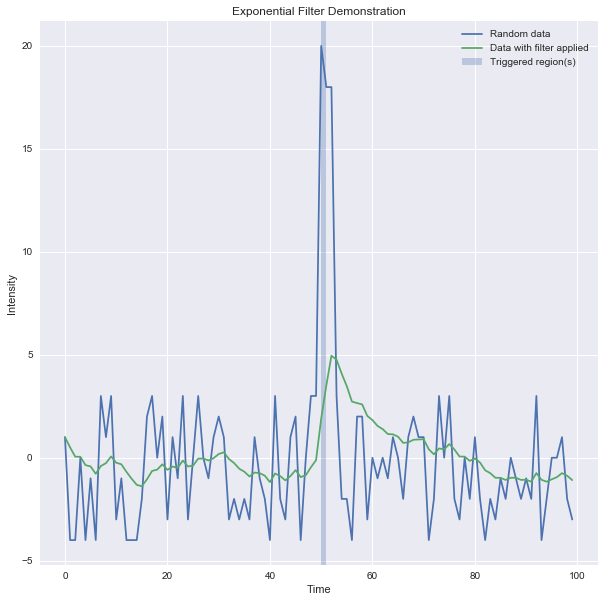

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def expofilter(data, alpha):
    """Apply the exponential filter to given data.

    The filter function is defined recurively by:
    𝑓_0 = 𝑥_0,
    𝑓_𝑖+1 = 𝛼𝑓_𝑖 + (1 − 𝛼)𝑥_𝑖+1    𝑖 > 0.
    for each value 𝑥 in data.
    Parameters:
    -----------
    data: np.ndarray the data to apply the filter to.

    alpha: float value alpha (𝛼) to be used in the
    filter function as defined above.
    Returns:
    --------
    filtered: np.ndarray of the data with the filter
    applied.
    """
    filtered = np.zeros(len(data))
    filtered[0] = data[0]
    for i in range(1, len(data)):
        filtered[i] = alpha * filtered[i - 1] + (1 - alpha) * data[i]
    return filtered


def changeDetect(data, alpha, threshold):
    """Find points in data where a change occurs.

    Use expofilter to create a filtered array and then
    find the points in the array where it jumps by more
    than threshold.
    Parameters:
    -----------
    data: np.ndarray the data to find changes in.

    alpha: the values of alpha (𝛼) to use in expofilter.

    threshold: float value at which to register a change.
    Returns:
    --------
    filtered: np.ndarray the data with the expofilter applied.

    trigger_points: nd.ndarray of int the indices of points where
    changes were detected.
    See also:
    ---------
    expofilter
    """
    filtered = expofilter(data, alpha)
    change_values = np.abs(np.diff(filtered))
    # here 1 is added to account for np.diff shifting the indices
    trigger_points = np.where(change_values > threshold)[0] + 1
    return filtered, trigger_points


def identify_regions(trigger_points):
    """Locate discrete regions that continuallly trigger the filter.

    Take an array of trigger points and split it into connected
    sections defined by start and end points.
    Parameters:
    -----------
    trigger_points: np.ndarray of int of the indices of points
    at which the filter was triggered.
    Returns:
    --------
    regions: list of tuples containing start and end indices
    of the regions identified.
    See also:
    ---------
    changeDetect
    """
    diff = np.diff(trigger_points)
    # again add 1 to account for np.diff shift
    jumps = np.where(diff > 1)[0] + 1
    split = np.split(trigger_points, jumps)
    return [(min(arr), max(arr)) for arr in split]


# set some parameters for later
alpha = 0.9
threshold = 1.5

# generate random data and apply filter
random_data = np.random.randint(-4, 4, 100)
random_data[50:53] += 20
filter_data, trigger_points = changeDetect(random_data, alpha, threshold)

# plot the data
plt.style.use("seaborn")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(random_data, label="Random data")
ax.plot(filter_data, label="Data with filter applied")

# show regions where the filter triggers
trigger_regions = identify_regions(trigger_points)
for region in trigger_regions:
    last = ax.axvspan(region[0], region[-1], alpha=0.3)
# this trick means only a single region appears on the legend
last.set_label("Triggered region(s)")

# graph labels and such
ax.set_title("Exponential Filter Demonstration")
ax.set_xlabel("Time")
ax.set_ylabel("Intensity")
plt.legend()
plt.show()

In [2]:
# Test cell
data = np.random.randint(-4, 4, 100)
data[50] += 20
data[51] += 20
data[52] += 20
bf1, bf2 = changeDetect(data, 0.85, 1.5)
assert bf2[0] == 50, "wrong alarm start position"

In [3]:
# Test cell
data[48] += 30
bf1, bf2 = changeDetect(data, 0.87, 1.5)
# check modified data
assert bf2[0] == 48 and len(bf2) > 1, "fail on modified data"

### Tests - 3 marks; Style - 1 mark; Plot - 2 marks